# Kernel Methods for Machine Learning - Kaggle Data Challenge

- Victor Girou
- Maxence Gollier 

## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import optimize
from scipy.linalg import cho_factor, cho_solve
from skimage.feature import hog
from sklearn.decomposition import PCA

from SVC_cvx import KernelSVC

## Kernels

In [2]:
class RBF:
    def __init__(self, sigma=1.):
        self.sigma = sigma  ## the variance of the kernel
    def kernel(self, X, Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        X_norm = np.repeat(np.sum(X**2, axis=1).reshape(1, X.shape[0]), Y.shape[0], axis=0).T
        Y_norm = np.repeat(np.sum(Y**2, axis=1).reshape(1, Y.shape[0]), X.shape[0], axis=0)
        return np.exp(-(X_norm - 2*X@Y.T + Y_norm)/(2*self.sigma**2)) 
    
class Linear:
    def kernel(self, X, Y):
        ## Input vectors X and Y of shape Nxd and Mxd
        return X @ Y.T## Matrix of shape NxM

In [3]:
class Polynomial:
    def __init__(self,p = 1.,c = 0.0):
        self.p = p
        self.c = c
    def kernel(self,X,Y):
        return (np.dot(X,Y.T)+self.c*np.ones((X.shape[0],Y.shape[0])))**self.p # Matrix of shape NxM

In [4]:
class Laplace:
    def __init__(self,gamma):
        self.gamma = gamma
    def kernel(self,X,Y):

        X_norm = np.repeat(np.sum(X**2, axis=1).reshape(1, X.shape[0]), Y.shape[0], axis=0).T
        Y_norm = np.repeat(np.sum(Y**2, axis=1).reshape(1, Y.shape[0]), X.shape[0], axis=0)
        return np.exp(-np.sqrt(np.abs(X_norm - 2*X@Y.T + Y_norm))*self.gamma)   ## Matrix of shape NxM

In [5]:
class HIK:

    def __init__(self, beta=0.25):
        self.beta = beta 

    def kernel(self, X, Y):

        K = np.zeros((X.shape[0], Y.shape[0]))
        
        for d in range(X.shape[1]):
            column_1 = (np.abs(X[:, d])**self.beta).reshape(-1, 1)
            column_2 = (np.abs(Y[:, d])**self.beta).reshape(-1, 1)
            K += np.minimum(column_1, column_2.T)

        return K ## Matrix of shape NxM

## Data preparation

In [6]:
train_df = pd.read_csv('Xtr.csv', header=None)
Y = pd.read_csv('Ytr.csv')
label = Y['Prediction'].to_numpy()

In [7]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,3072
0,0.007018,0.000323,0.002215,0.000781,-0.005636,-0.001525,-0.001090,-0.001907,0.004179,-0.004225,...,-0.002166,-0.005094,0.001906,-0.006143,-0.013265,-0.013873,0.005223,-0.000860,-0.012881,NaN
1,0.000819,0.001688,0.002698,0.004685,0.011166,0.017482,0.045989,0.031377,0.032150,0.062066,...,0.007203,0.008634,0.006800,0.014114,0.000243,-0.019384,-0.046763,-0.048919,-0.057449,NaN
2,-0.016779,0.006662,-0.007226,-0.003798,-0.004273,-0.009955,-0.030925,-0.007064,0.008136,0.000618,...,-0.023748,0.047707,0.072310,0.056837,0.045410,0.015561,0.003272,-0.013745,0.000968,NaN
3,0.014936,0.004218,0.009732,0.007309,0.004914,0.008172,0.014205,-0.023263,-0.023014,0.011482,...,-0.029634,-0.024069,-0.000788,-0.005010,-0.004260,0.014308,-0.010997,-0.025966,-0.025786,NaN
4,-0.073091,-0.046800,-0.056235,-0.063619,-0.088387,-0.044682,-0.014172,-0.077535,-0.100056,-0.066161,...,-0.018166,0.012983,0.022676,0.014233,0.047403,0.052239,-0.029272,0.001368,-0.001475,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-0.021390,0.029503,-0.002429,0.006146,-0.011715,-0.014993,0.000653,-0.015904,-0.037338,-0.076354,...,0.006321,-0.003823,-0.004482,0.007168,0.007442,0.008854,-0.004593,-0.000920,-0.017339,NaN
4996,-0.028515,-0.031435,-0.012834,-0.029745,0.021972,0.003324,0.023001,0.029703,-0.038012,0.059018,...,-0.007123,-0.064752,-0.078392,-0.074313,-0.029270,0.056367,0.054470,0.010949,0.062182,NaN
4997,0.049680,0.050423,0.012001,-0.003546,0.011553,0.000293,0.003198,0.016430,-0.010582,-0.019450,...,0.009501,0.014085,0.010988,0.011975,0.018873,-0.010400,-0.013394,-0.015530,-0.001548,NaN
4998,0.000044,0.000599,0.000182,0.000025,-0.000004,0.000004,0.000000,0.000000,0.000000,0.000000,...,0.061100,0.017464,0.011662,0.036202,0.025268,0.020164,0.016163,0.025354,0.034644,NaN


In [8]:
data = train_df.to_numpy()

In [9]:
data

array([[ 7.018306e-03,  3.232710e-04,  2.214609e-03, ..., -8.603970e-04,
        -1.288091e-02,           nan],
       [ 8.188180e-04,  1.688266e-03,  2.697502e-03, ..., -4.891890e-02,
        -5.744892e-02,           nan],
       [-1.677857e-02,  6.661847e-03, -7.225712e-03, ..., -1.374493e-02,
         9.684803e-04,           nan],
       ...,
       [ 4.967951e-02,  5.042284e-02,  1.200120e-02, ..., -1.553006e-02,
        -1.548077e-03,           nan],
       [ 4.416555e-05,  5.989731e-04,  1.818997e-04, ...,  2.535399e-02,
         3.464407e-02,           nan],
       [ 2.334076e-02, -4.589959e-03, -1.103150e-02, ..., -2.562464e-02,
         1.402059e-02,           nan]])

In [10]:
# remove NaN in the last column 
data = data[:,:-1]

In [11]:
train_indexes_list = np.random.choice(np.arange(0, len(data)), size=int(0.8*len(data)), replace=False)
val_indexes_list = [i for i in range(len(data)) if i not in train_indexes_list]

In [12]:
# train test split 
trainset = [[(np.array(image[i*1024:(i+1)*1024]) - np.mean(image[i*1024:(i+1)*1024])).reshape(32, 32)/np.std(np.array(image[i*1024:(i+1)*1024])) for i in range(3)] for image in data[train_indexes_list]]
valset = [[(np.array(image[i*1024:(i+1)*1024]) - np.mean(image[i*1024:(i+1)*1024])).reshape(32, 32)/np.std(np.array(image[i*1024:(i+1)*1024])) for i in range(3)] for image in data[val_indexes_list]]

label_train = label[train_indexes_list]
label_val = label[val_indexes_list]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


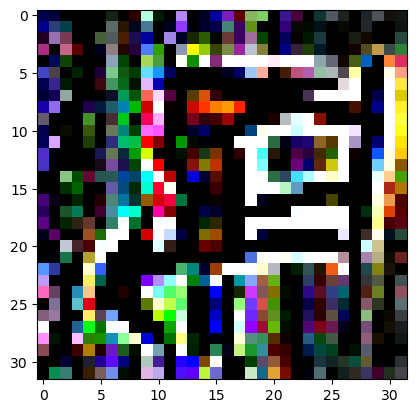

In [13]:
plt.imshow(np.transpose(trainset[0], axes=(2, 1, 0)))

In [14]:
# Compute hog features
trainset_transfo = [hog(image, channel_axis=0).flatten() for image in trainset]
valset_transfo = [hog(image, channel_axis=0).flatten() for image in valset]

## Hyperparameter optimization

In this section we will perform a K-fold cross validation to optimize the hyperparameters of the problem and/or compare different models. To do that we only need to define the model in the following cells.

In [15]:
K = 5
# define the K-fold
folds_idx = np.random.choice(np.arange(0, len(trainset_transfo)), size=(K, int(0.2*len(trainset_transfo))), replace=False)
folds = [np.array(trainset_transfo)[f] for f in folds_idx]

In [19]:
score_model = []

for k in range(K):

    indexes_train = {}
    indexes_val = {}
    classifiers = {}
    label_train_dict = {}
    label_val_dict = {}

    train_fold_idx = np.concatenate([folds_idx[:k], folds_idx[k+1:]])

    for i in range(0, 9):
        label_train_dict[str(i)] = np.array([1 if l==i else -1 for l in label_train])
        label_val_dict[str(i)] = np.array([1 if l==i else -1 for l in label_val])
        for j in range(i+1, 10):
            # define the training and validation set for the one vs one classification
            indexes_train[str(i)+str(j)] = np.array([k for k, l in enumerate(label_train) if ((l==i or l==j) and k in train_fold_idx)])
            indexes_val[str(i)+str(j)] = np.array([k for k, l in enumerate(label_val) if l==i or l==j])
            # define classifier
            classifiers[str(i)+str(j)] = KernelSVC(C=0.5, kernel=HIK(beta=4).kernel, epsilon=0)
    
    y_predict = {}

    for i in range(0, 9):
        for j in range(i+1, 10):
            print(str(i) + str(j))
            classifiers[str(i)+str(j)].fit(np.array(trainset_transfo)[indexes_train[str(i)+str(j)]], label_train_dict[str(i)][indexes_train[str(i)+str(j)]])
            # prediction on validation set for the binary classification
            y_predict[str(i)+str(j)] = classifiers[str(i)+str(j)].predict(np.array(trainset_transfo)[folds_idx[k]])
    
    # prediction on the validation set for the multi-class problem
    val_pred = {}

    for i in range(0, 10):

        val_pred[str(i)] = []

        for j in range(i):

            val_pred[str(i)].append(-y_predict[str(j)+str(i)])
        
        for j in range(i+1, 10):

            val_pred[str(i)].append(y_predict[str(i)+str(j)])
    
    final_pred = np.array([np.sum(val_pred[str(i)], axis=0) for i in range(10)])
    multiclass_pred = np.argmax(final_pred, axis=0)

    # compute score 
    
    score = np.sum(multiclass_pred==label_train[folds_idx[k]])/len(folds_idx[k])
    
    score_model.append(score)

01
     pcost       dcost       gap    pres   dres
 0: -3.3308e+02 -7.5167e+02  4e+03  4e+00  8e-16
 1: -2.0248e+02 -6.0852e+02  4e+02  1e-14  6e-16
 2: -2.3522e+02 -2.7138e+02  4e+01  1e-14  6e-16
 3: -2.4868e+02 -2.6591e+02  2e+01  9e-16  4e-16
 4: -2.5472e+02 -2.6281e+02  8e+00  6e-15  3e-16
 5: -2.5798e+02 -2.6093e+02  3e+00  7e-15  4e-16
 6: -2.5929e+02 -2.6012e+02  8e-01  4e-15  4e-16
 7: -2.5975e+02 -2.5981e+02  7e-02  2e-15  4e-16
 8: -2.5979e+02 -2.5979e+02  1e-03  5e-16  5e-16
 9: -2.5979e+02 -2.5979e+02  2e-05  2e-15  4e-16
Optimal solution found.
02
     pcost       dcost       gap    pres   dres
 0: -3.0931e+02 -7.4220e+02  4e+03  5e+00  7e-16
 1: -1.7934e+02 -6.0330e+02  4e+02  8e-15  5e-16
 2: -2.0648e+02 -2.4958e+02  4e+01  4e-15  7e-16
 3: -2.2370e+02 -2.3788e+02  1e+01  4e-15  4e-16
 4: -2.2952e+02 -2.3345e+02  4e+00  5e-15  4e-16
 5: -2.3114e+02 -2.3222e+02  1e+00  3e-15  4e-16
 6: -2.3163e+02 -2.3181e+02  2e-01  4e-15  4e-16
 7: -2.3172e+02 -2.3173e+02  6e-03  2e-15

In [20]:
print('Mean: ', np.mean(score_model))
print('Standard Deviation: ', np.std(score_model))

Mean:  0.1685
Standard Deviation:  0.014017845768876191


## Training

### Model and dataset constructions

In [257]:
indexes_train = {}
indexes_val = {}
classifiers = {}
label_train_dict = {}
label_val_dict = {}

for i in range(0, 9):
    label_train_dict[str(i)] = np.array([1 if l==i else -1 for l in label_train])
    label_val_dict[str(i)] = np.array([1 if l==i else -1 for l in label_val])
    for j in range(i+1, 10):
        indexes_train[str(i)+str(j)] = np.array([k for k, l in enumerate(label_train) if l==i or l==j])
        indexes_val[str(i)+str(j)] = np.array([k for k, l in enumerate(label_val) if l==i or l==j])
        # define the classifier 
        classifiers[str(i)+str(j)] = KernelSVC(C=10, kernel=RBF(sigma=0.5).kernel, epsilon=0)


### Training

In [258]:
y_predict = {}

for i in range(0, 9):
    for j in range(i+1, 10):
        print(str(i) + str(j))
        classifiers[str(i)+str(j)].fit(np.array(trainset_transfo)[indexes_train[str(i)+str(j)]], label_train_dict[str(i)][indexes_train[str(i)+str(j)]])
        y_predict[str(i)+str(j)] = classifiers[str(i)+str(j)].predict(np.array(valset_transfo))

01
     pcost       dcost       gap    pres   dres
 0:  3.3617e+03 -3.3407e+04  4e+04  2e-13  6e-15
 1:  7.1544e+02 -3.6628e+03  4e+03  4e-14  3e-15
 2: -1.5568e+02 -6.6141e+02  5e+02  9e-14  1e-15
 3: -2.3517e+02 -2.7608e+02  4e+01  5e-14  5e-16
 4: -2.3773e+02 -2.3967e+02  2e+00  5e-15  2e-16
 5: -2.3793e+02 -2.3801e+02  8e-02  5e-15  2e-16
 6: -2.3795e+02 -2.3795e+02  4e-03  3e-15  2e-16
 7: -2.3795e+02 -2.3795e+02  2e-04  3e-15  2e-16
Optimal solution found.
02
     pcost       dcost       gap    pres   dres
 0:  3.1264e+03 -3.6112e+04  4e+04  2e-14  6e-15
 1:  6.9882e+02 -3.8523e+03  5e+03  7e-16  3e-15
 2: -1.8119e+02 -7.1623e+02  5e+02  2e-14  1e-15
 3: -2.6067e+02 -3.0308e+02  4e+01  9e-15  5e-16
 4: -2.6309e+02 -2.6515e+02  2e+00  2e-14  2e-16
 5: -2.6329e+02 -2.6338e+02  9e-02  2e-14  2e-16
 6: -2.6332e+02 -2.6332e+02  5e-03  2e-15  2e-16
 7: -2.6332e+02 -2.6332e+02  3e-04  9e-16  2e-16
 8: -2.6332e+02 -2.6332e+02  2e-05  2e-15  2e-16
Optimal solution found.
03
     pcost    

### Evaluation

In [259]:
val_pred = {}

for i in range(0, 10):

    val_pred[str(i)] = []

    for j in range(i):

        val_pred[str(i)].append(-y_predict[str(j)+str(i)])
    
    for j in range(i+1, 10):

        val_pred[str(i)].append(y_predict[str(i)+str(j)])

In [260]:
final_pred = np.array([np.sum(val_pred[str(i)], axis=0) for i in range(10)])
multiclass_pred = np.argmax(final_pred, axis=0)

In [263]:
# compute accuracy
print('Accuracy: ', np.sum(multiclass_pred==label_val)/len(label_val))

0.564

## Prediction for Submission

In [95]:
test_df = pd.read_csv('Xte.csv', header=None)
data_test = test_df.to_numpy()

In [96]:
# remove NaN in the last column
data_test = data_test[:,:-1]

In [97]:
testset = [[(np.array(image[i*1024:(i+1)*1024]) - np.mean(image[i*1024:(i+1)*1024])).reshape(32, 32)/np.std(np.array(image[i*1024:(i+1)*1024])) for i in range(3)] for image in data_test]
# extract hog features
testset_transfo = [hog(image, channel_axis=0).flatten() for image in testset]

In [98]:
test_predict = {}

for i in range(0, 9):
    for j in range(i+1, 10):
        print(str(i) + str(j))
        test_predict[str(i)+str(j)] = classifiers[str(i)+str(j)].predict(np.array(testset_transfo))

01
02
03
04
05
06
07
08
09
12
13
14
15
16
17
18
19
23
24
25
26
27
28
29
34
35
36
37
38
39
45
46
47
48
49
56
57
58
59
67
68
69
78
79
89


In [99]:
test_pred = {}

for i in range(0, 10):

    test_pred[str(i)] = []

    for j in range(i):

        test_pred[str(i)].append(-test_predict[str(j)+str(i)])
    
    for j in range(i+1, 10):

        test_pred[str(i)].append(test_predict[str(i)+str(j)])

In [100]:
final_pred = np.array([np.sum(test_pred[str(i)], axis=0) for i in range(10)])
# compute final prediction
multiclass_pred = np.argmax(final_pred, axis=0)

In [102]:
submission = pd.DataFrame({'Prediction':multiclass_pred})

In [103]:
submission

,Prediction
0,6
1,7
2,9
3,9
4,9
...,...
1995,9
1996,8
1997,6
1998,4


In [104]:
submission.index += 1
submission.to_csv('soumission_SVM_OvO.csv', index_label='Id')